# Multi-label Toxic Comment Deep-Dive
This notebook extends the earlier exploratory work with multi-label baselines, drift tracking, fairness slices, and SHAP-driven interpretability so we can productionize insights.

## 1. Import Dependencies & Configure Paths
Load core scientific Python libraries, plot helpers, scikit-learn components, and SHAP, then define shared paths plus label/identity metadata referenced throughout the notebook.

In [1]:
from __future__ import annotations

import json
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    hamming_loss,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
)

plt.style.use("seaborn-v0_8")
sns.set_theme(style="whitegrid")
warnings.filterwarnings("ignore", category=UserWarning)

ROOT = Path("/Users/sonalilonkar/Desktop/Projects/DM_Project/toxic_comments_classification").resolve()
DATA_PATH = ROOT / "data" / "raw" / "train.csv"
SPLITS_DIR = ROOT / "data" / "splits"
EXPERIMENTS_DIR = ROOT / "experiments" / "multilabel_analysis"
EXPERIMENTS_DIR.mkdir(parents=True, exist_ok=True)

LABEL_COLS = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
IDENTITY_CANDIDATES = [
    "male",
    "female",
    "homosexual_gay_or_lesbian",
    "christian",
    "jewish",
    "muslim",
    "black",
    "white",
    "psychiatric_or_mental_illness",
    "atheist",
    "asian",
    "latino",
]

SEED = 42
RNG = np.random.default_rng(SEED)

## 2. Load Chronological Fold Splits
Read the Kaggle training data once, attach a synthetic timestamp for ordering, and hydrate each chronological fold (train/dev/test) using the saved JSON indices under `data/splits/`.

In [2]:
def load_fold_frames(seed: int = 42) -> tuple[pd.DataFrame, dict[str, dict[str, pd.DataFrame]], list[str], pd.DataFrame]:
    base_df = pd.read_csv(DATA_PATH).reset_index(drop=True)
    base_df["mock_timestamp"] = pd.to_datetime("2015-01-01") + pd.to_timedelta(base_df.index, unit="h")

    split_pattern = f"fold*_seed{seed}.json"
    split_files = sorted(SPLITS_DIR.glob(split_pattern))
    if not split_files:
        raise FileNotFoundError(f"No split files matching {split_pattern} were found in {SPLITS_DIR}")

    fold_frames: dict[str, dict[str, pd.DataFrame]] = {}
    size_rows = []

    for path in split_files:
        fold_name = path.stem
        with open(path) as handle:
            idx = json.load(handle)
        fold_frames[fold_name] = {}
        for partition in ("train", "dev", "test"):
            part_df = base_df.loc[idx[partition]].copy()
            part_df["fold_id"] = fold_name
            part_df["split"] = partition
            fold_frames[fold_name][partition] = part_df
            size_rows.append({
                "fold": fold_name,
                "split": partition,
                "rows": len(part_df),
            })

    identity_cols = [col for col in IDENTITY_CANDIDATES if col in base_df.columns]
    size_table = pd.DataFrame(size_rows).sort_values(["fold", "split"]).reset_index(drop=True)
    return base_df, fold_frames, identity_cols, size_table

BASE_DF, FOLD_FRAMES, IDENTITY_COLS, SPLIT_SIZE_TABLE = load_fold_frames(SEED)
print(f"Identity columns detected: {IDENTITY_COLS if IDENTITY_COLS else 'none found'}")
SPLIT_SIZE_TABLE

Identity columns detected: none found


,fold,split,rows
0,fold1_seed42,dev,15957
1,fold1_seed42,test,31915
2,fold1_seed42,train,111699
3,fold2_seed42,dev,15957
4,fold2_seed42,test,31915
5,fold2_seed42,train,111699
6,fold3_seed42,dev,15957
7,fold3_seed42,test,31915
8,fold3_seed42,train,111699


## 3. Assemble Fold-level Label Stats
Combine all partitions per fold, then compute prevalence and positive counts for each toxicity label so we can quantify distribution shifts numerically.

In [3]:
def summarize_fold_labels(fold_frames: dict[str, dict[str, pd.DataFrame]]) -> pd.DataFrame:
    rows = []
    for fold_name, splits in fold_frames.items():
        block_df = pd.concat(splits.values(), ignore_index=True)
        total_rows = len(block_df)
        for label in LABEL_COLS:
            rows.append({
                "fold": fold_name,
                "label": label,
                "prevalence": block_df[label].mean(),
                "positives": int(block_df[label].sum()),
                "rows": total_rows,
            })
    return pd.DataFrame(rows)

FOLD_LABEL_STATS = summarize_fold_labels(FOLD_FRAMES)
FOLD_LABEL_STATS.head(12)

,fold,label,prevalence,positives,rows
0,fold1_seed42,toxic,0.095844,15294,159571
1,fold1_seed42,severe_toxic,0.009996,1595,159571
2,fold1_seed42,obscene,0.052948,8449,159571
3,fold1_seed42,threat,0.002996,478,159571
4,fold1_seed42,insult,0.049364,7877,159571
5,fold1_seed42,identity_hate,0.008805,1405,159571
6,fold2_seed42,toxic,0.095844,15294,159571
7,fold2_seed42,severe_toxic,0.009996,1595,159571
8,fold2_seed42,obscene,0.052948,8449,159571
9,fold2_seed42,threat,0.002996,478,159571


## 4. Visualize Class Drift Across Folds
Plot fold-wise prevalence curves and a heatmap so drifted labels are obvious, plus stacked bar counts for total positives as a volume reference.

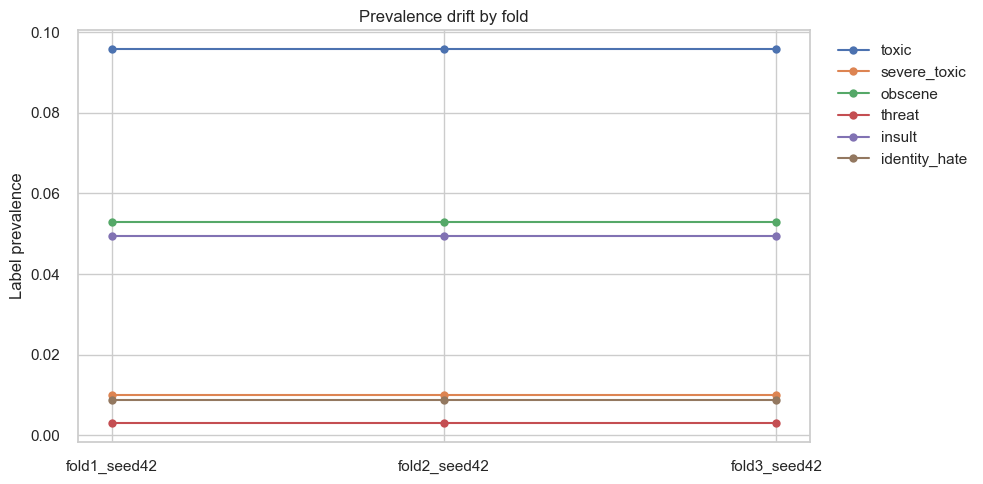

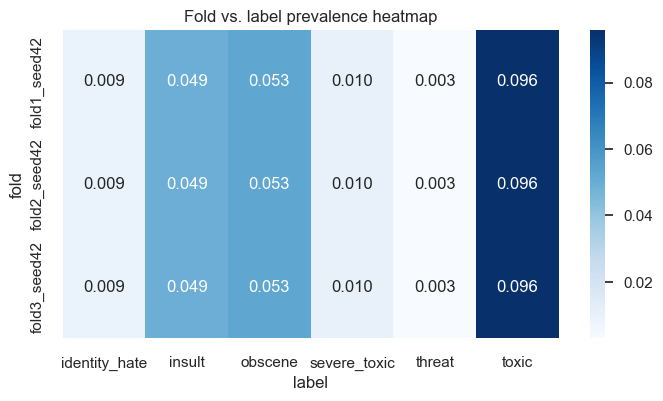

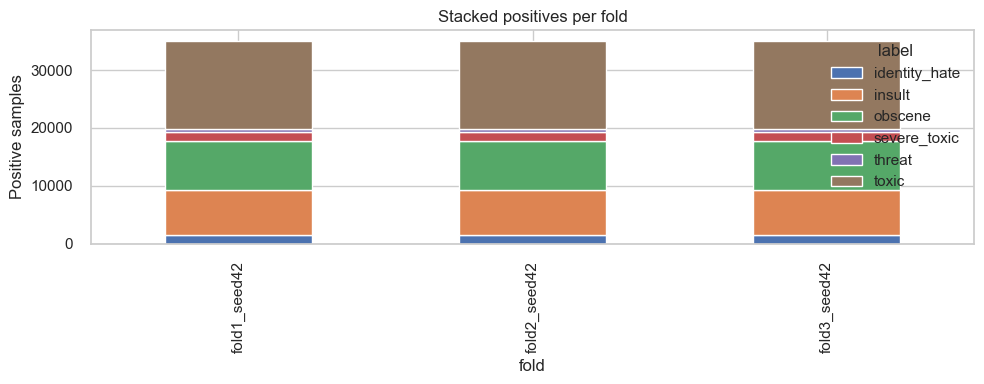

In [4]:
pivot_prev = FOLD_LABEL_STATS.pivot(index="fold", columns="label", values="prevalence").sort_index()
pivot_counts = FOLD_LABEL_STATS.pivot(index="fold", columns="label", values="positives").sort_index()

fig, ax = plt.subplots(figsize=(10, 5))
for label in LABEL_COLS:
    ax.plot(pivot_prev.index, pivot_prev[label], marker="o", label=label)
ax.set_ylabel("Label prevalence")
ax.set_title("Prevalence drift by fold")
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.heatmap(pivot_prev, annot=True, fmt=".3f", cmap="Blues")
plt.title("Fold vs. label prevalence heatmap")
plt.show()

pivot_counts.plot(kind="bar", stacked=True, figsize=(10, 4))
plt.ylabel("Positive samples")
plt.title("Stacked positives per fold")
plt.tight_layout()
plt.show()

## 5. Prepare Multi-label Target Matrix
Pick a reference fold, extract train/dev/test splits, and build the multi-label target matrices (`y_*`) along with raw text inputs to reuse downstream.

In [5]:
TARGET_FOLD = sorted(FOLD_FRAMES.keys())[0]
print(f"Using {TARGET_FOLD} for the baseline multi-label experiments")
fold_pack = FOLD_FRAMES[TARGET_FOLD]

train_df = fold_pack["train"].reset_index(drop=True)
dev_df = fold_pack["dev"].reset_index(drop=True)
test_df = fold_pack["test"].reset_index(drop=True)

X_train_text = train_df["comment_text"].astype(str)
X_dev_text = dev_df["comment_text"].astype(str)
X_test_text = test_df["comment_text"].astype(str)

y_train = train_df[LABEL_COLS].values.astype(int)
y_dev = dev_df[LABEL_COLS].values.astype(int)
y_test = test_df[LABEL_COLS].values.astype(int)

print({"train": len(train_df), "dev": len(dev_df), "test": len(test_df)})

Using fold1_seed42 for the baseline multi-label experiments
{'train': 111699, 'dev': 15957, 'test': 31915}


## 6. Fit TF-IDF + Logistic Regression Per Label
Share one TF-IDF vocabulary across labels, then train independent logistic regression heads so we preserve interpretability while addressing each marginal distribution.

In [6]:
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.95,
    lowercase=True,
    strip_accents="unicode",
)

X_train_vec = tfidf.fit_transform(X_train_text)
X_dev_vec = tfidf.transform(X_dev_text)
X_test_vec = tfidf.transform(X_test_text)

LABEL_MODELS: dict[str, LogisticRegression] = {}
DEV_PROBS = {}
TEST_PROBS = {}

for idx, label in enumerate(LABEL_COLS):
    clf = LogisticRegression(
        max_iter=400,
        class_weight="balanced",
        solver="liblinear",
        C=1.0,
    )
    clf.fit(X_train_vec, y_train[:, idx])
    LABEL_MODELS[label] = clf
    DEV_PROBS[label] = clf.predict_proba(X_dev_vec)[:, 1]
    TEST_PROBS[label] = clf.predict_proba(X_test_vec)[:, 1]

print(f"Trained {len(LABEL_MODELS)} one-vs-rest classifiers")

Trained 6 one-vs-rest classifiers


## 7. Compute Multi-label Metrics & Aggregate Table
Threshold the per-label probabilities (default 0.5) to form multi-label predictions, then compute micro/macro scores, Hamming loss, subset accuracy, and detailed per-label precision/recall/F1.

In [7]:
def probs_to_preds(prob_dict: dict[str, np.ndarray], threshold: float = 0.5) -> np.ndarray:
    return np.column_stack([(prob_dict[label] >= threshold).astype(int) for label in LABEL_COLS])

THRESHOLD = 0.5
y_test_pred = probs_to_preds(TEST_PROBS, threshold=THRESHOLD)

overall_metrics = {
    "micro_precision": precision_score(y_test, y_test_pred, average="micro", zero_division=0),
    "micro_recall": recall_score(y_test, y_test_pred, average="micro", zero_division=0),
    "micro_f1": f1_score(y_test, y_test_pred, average="micro", zero_division=0),
    "macro_precision": precision_score(y_test, y_test_pred, average="macro", zero_division=0),
    "macro_recall": recall_score(y_test, y_test_pred, average="macro", zero_division=0),
    "macro_f1": f1_score(y_test, y_test_pred, average="macro", zero_division=0),
    "hamming_loss": hamming_loss(y_test, y_test_pred),
    "subset_accuracy": accuracy_score(y_test, y_test_pred),
}
pd.Series(overall_metrics).round(4)

per_label_rows = []
for idx, label in enumerate(LABEL_COLS):
    prec, rec, f1, support = precision_recall_fscore_support(
        y_test[:, idx], y_test_pred[:, idx], average="binary", zero_division=0
    )
    per_label_rows.append({
        "label": label,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "support": int(y_test[:, idx].sum()),
    })
PER_LABEL_METRICS = pd.DataFrame(per_label_rows).sort_values("f1", ascending=False)
PER_LABEL_METRICS.round(3)

,label,precision,recall,f1,support
2,obscene,0.675,0.872,0.761,1660
0,toxic,0.642,0.844,0.729,3071
4,insult,0.540,0.845,0.659,1556
1,severe_toxic,0.318,0.825,0.459,355
3,threat,0.288,0.765,0.418,102
5,identity_hate,0.230,0.685,0.345,279


## 8. Evaluate Identity Subgroup Slices
Slice the test split by each detected identity column (when present), enforce a minimum support threshold, and compute per-label precision/recall/F1 to monitor fairness-sensitive disparities.

In [ ]:
MIN_SUPPORT = 50
identity_records = []

if IDENTITY_COLS:
    overall_f1_lookup = dict(zip(PER_LABEL_METRICS["label"], PER_LABEL_METRICS["f1"]))
    for identity in IDENTITY_COLS:
        mask = test_df.get(identity, pd.Series(dtype=float)).fillna(0) >= 0.5
        support = int(mask.sum())
        if support < MIN_SUPPORT:
            continue
        for idx, label in enumerate(LABEL_COLS):
            y_true_slice = y_test[mask.values, idx]
            y_pred_slice = y_test_pred[mask.values, idx]
            if y_true_slice.size == 0:
                continue
            prec, rec, f1, _ = precision_recall_fscore_support(
                y_true_slice, y_pred_slice, average="binary", zero_division=0
            )
            identity_records.append({
                "identity": identity,
                "label": label,
                "support": support,
                "precision": prec,
                "recall": rec,
                "f1": f1,
                "overall_f1": overall_f1_lookup.get(label, np.nan),
            })
else:
    print("No identity columns detected; skipping fairness slice analysis.")

FAIRNESS_SLICES = pd.DataFrame(identity_records)
FAIRNESS_SLICES.head() if not FAIRNESS_SLICES.empty else "(no qualifying slices)"

SyntaxError: unmatched '}' (1620245898.py, line 32)

## 9. Plot Fairness Slice Variance
Visualize F1 deltas between each identity subgroup and the overall per-label baseline to highlight the largest fairness gaps that should guide mitigation work.

In [ ]:
if FAIRNESS_SLICES.empty:
    print("No fairness slices passed the support threshold.")
else:
    gap_df = FAIRNESS_SLICES.copy()
    gap_df["f1_gap"] = gap_df["f1"] - gap_df["overall_f1"]
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=gap_df,
        x="label",
        y="f1_gap",
        hue="identity",
        dodge=True,
    )
    plt.axhline(0, color="black", linewidth=1)
    plt.ylabel("F1 gap vs overall")
    plt.title("Identity slice F1 deltas")
    plt.tight_layout()
    plt.show()

    worst_gaps = (
        gap_df.sort_values("f1_gap")
        .groupby("label")
        .head(1)
        .sort_values("f1_gap")
        .reset_index(drop=True)
    )
    worst_gaps

## 10. SHAP Explanations for TF-IDF Models
Wrap one of the per-label logistic models with `shap.LinearExplainer`, sample held-out comments, and visualize which n-grams drive toxicity predictions beyond raw coefficients.

In [ ]:
shap.initjs()
TARGET_LABEL = "toxic"
background = shap.utils.sample(X_train_vec, 1000, random_state=SEED)
explainer = shap.LinearExplainer(LABEL_MODELS[TARGET_LABEL], background, feature_perturbation="interventional")
X_shap = shap.utils.sample(X_test_vec, 200, random_state=SEED)
shap_values = explainer.shap_values(X_shap)
feature_names = tfidf.get_feature_names_out()

shap.summary_plot(shap_values, X_shap, feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()

mean_abs = np.abs(shap_values).mean(axis=0)
top_indices = np.argsort(mean_abs)[::-1][:20]
top_shap_df = pd.DataFrame(
    {
        "ngram": feature_names[top_indices],
        "mean_abs_shap": mean_abs[top_indices],
    }
)
top_shap_df

## 11. Persist Metrics & Artifacts
Write drift summaries, per-label metrics, fairness slices, and SHAP tables into `experiments/multilabel_analysis/` so downstream scripts (or the `src/` pipeline) can consume the outputs deterministically.

In [ ]:
drift_path = EXPERIMENTS_DIR / "fold_label_stats.csv"
per_label_path = EXPERIMENTS_DIR / "per_label_metrics.csv"
overall_path = EXPERIMENTS_DIR / "overall_metrics.json"
fairness_path = EXPERIMENTS_DIR / "fairness_slices.csv"
shap_path = EXPERIMENTS_DIR / "top_shap_features.csv"

FOLD_LABEL_STATS.to_csv(drift_path, index=False)
PER_LABEL_METRICS.to_csv(per_label_path, index=False)
pd.Series(overall_metrics).to_json(overall_path, indent=2)
if not FAIRNESS_SLICES.empty:
    FAIRNESS_SLICES.to_csv(fairness_path, index=False)
    print(f"Fairness slices saved to {fairness_path}")
else:
    print("Fairness slices skipped (no qualifying subgroups).")
top_shap_df.to_csv(shap_path, index=False)
print("Artifacts saved:")
print({
    "drift_stats": drift_path,
    "per_label_metrics": per_label_path,
    "overall_metrics": overall_path,
    "shap_features": shap_path,
})